**COMP0120 Project Code - Support Vector Machines (SVMs)**

**John Duffy, Student Number: 19154676**

In [149]:
# Import libraries common to whole project.

import matplotlib.pyplot as plt
import numpy as np

In [150]:
# Load Iris dataset.

from sklearn import datasets
iris = datasets.load_iris()
X = iris["data"]
y = iris["target"]
y_names = iris["target_names"]

# Introduction

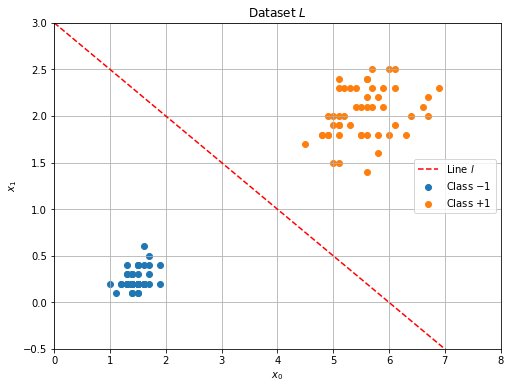

In [151]:
# intro_0.pdf

labels = ["Class $-1$", "Class $+1$"]
plt.figure(figsize=(8, 6))
plt.xlim(0, 8)
plt.ylim(-0.5, 3)
for i, value in enumerate([0, 2]):
    plt.scatter(X[y == value, 2], X[y == value, 3], label=labels[i])
x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -0.5
c = 3.0
x1 = m * x0 + c
plt.plot(x0, x1, "--r", label="Line $l$")
plt.title("Dataset $L$")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend(loc="center right")
plt.grid()
plt.savefig("intro_0.pdf")
plt.show()

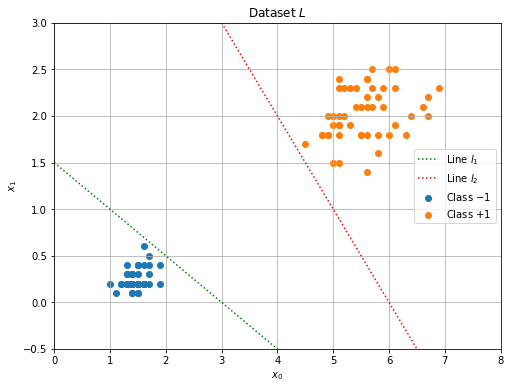

In [152]:
# intro_02.pdf

labels = ["Class $-1$", "Class $+1$"]
plt.figure(figsize=(8, 6))
plt.xlim(0, 8)
plt.ylim(-0.5, 3)
for i, value in enumerate([0, 2]):
    plt.scatter(X[y == value, 2], X[y == value, 3], label=labels[i])
x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -0.5
c = 1.5
x1 = m * x0 + c
plt.plot(x0, x1, ":g", label="Line $l_1$")
x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -1
c = 6
x1 = m * x0 + c
plt.plot(x0, x1, ":r", label="Line $l_2$")
plt.title("Dataset $L$")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend(loc="center right")
plt.grid()
plt.savefig("intro_1.pdf")
plt.show()

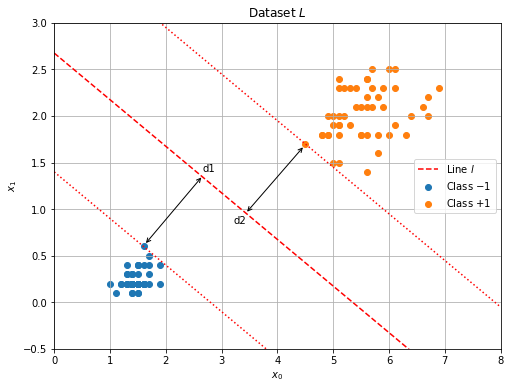

In [153]:
# intro_03.pdf

labels = ["Class $-1$", "Class $+1$"]

plt.figure(figsize=(8, 6))
plt.xlim(0, 8)
plt.ylim(-0.5, 3)

for i, value in enumerate([0, 2]):
    plt.scatter(X[y == value, 2], X[y == value, 3], label=labels[i])

x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -0.5
c = 1.4
x1 = m * x0 + c
plt.plot(x0, x1, ":r")

x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -0.5
c = 3.95
x1 = m * x0 + c
plt.plot(x0, x1, ":r")

x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -0.5
c = 2.675
x1 = m * x0 + c
plt.plot(x0, x1, "--r", label="Line $l$")

#plt.annotate("", xy=(0.80, 1.0), xytext=(2.9, 2.5), arrowprops=dict(arrowstyle="<->"))

plt.annotate("d1", xy=(1.62, 0.62), xytext=(2.65, 1.4), arrowprops=dict(arrowstyle="<->"))
plt.annotate("d2", xy=(4.48, 1.68), xytext=(3.21, 0.85), arrowprops=dict(arrowstyle="<->"))

plt.title("Dataset $L$")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend(loc="center right")
plt.grid()
plt.savefig("intro_2.pdf")
plt.show()

# Mathematical Setting

## Linear Binary Classification

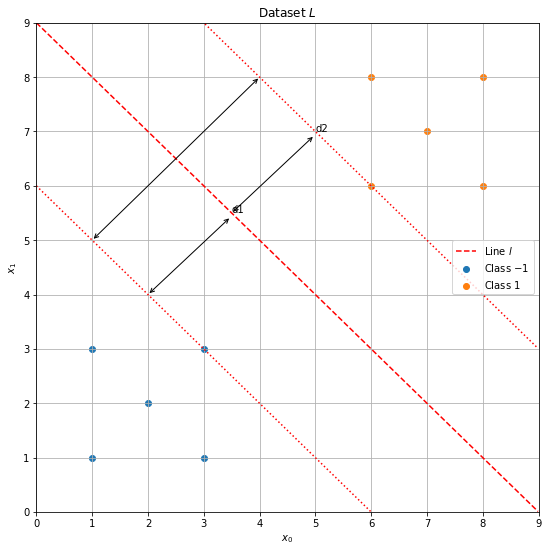

In [154]:
# linear_binary_0.pdf

plt.figure(figsize=(9, 9))
plt.xlim(0, 9)
plt.ylim(0, 9)

X = np.array([[1.0, 1.0], [1.0, 3.0], [2.0, 2.0], [3.0, 1.0], [3.0, 3.0],
              [6.0, 6.0], [6.0, 8.0], [8.0, 6.0], [8.0, 8.0], [7.0, 7.0]],
             dtype=np.float64)
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
y_names = ["Class $-1$", "Class $1$"]

for i in np.sort(np.unique(y)):
    plt.scatter(X[y == i, 0], X[y == i, 1], label=y_names[i])

x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -1.0
c = 9.0
x1 = m * x0 + c
plt.plot(x0, x1, "--r", label="Line $l$")

x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -1.0
c = 6.0
x1 = m * x0 + c
plt.plot(x0, x1, ":r")

x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -1.0
c = 12.0
x1 = m * x0 + c
plt.plot(x0, x1, ":r")

plt.annotate("", xy=(1.0, 5.0), xytext=(4.0, 8.0), arrowprops=dict(arrowstyle="<->"))
plt.annotate("d1", xy=(2.0, 4.0), xytext=(3.5, 5.5), arrowprops=dict(arrowstyle="<->"))
plt.annotate("d2", xy=(3.5, 5.5), xytext=(5.0, 7.0), arrowprops=dict(arrowstyle="<->"))

plt.title("Dataset $L$")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend(loc="center right")
plt.grid(zorder=0)
plt.savefig("linear_binary_0.pdf")
plt.show()

In [155]:
# Sepal Data
#plt.figure(figsize=(8, 6))
#for i in np.sort(np.unique(y)):
#    plt.scatter(X[y == i, 0], X[y == i, 1], label=y_names[i])
#plt.title("Sepal Data")
#plt.xlabel("Sepal Length")
#plt.ylabel("Sepal Width")
#plt.legend()
#plt.grid(zorder=0)
#plt.savefig("iris_sepal.pdf")
#plt.show()

# Petal Data
#plt.figure(figsize=(8, 6))
#for i in np.sort(np.unique(y)):
#    plt.scatter(X[y == i, 2], X[y == i, 3], label=y_names[i])
#plt.title("Petal Data")
#plt.xlabel("Petal Length")
#plt.ylabel("Petal Width")
#plt.legend()
#plt.grid(zorder=0)
#plt.savefig("iris_petal.pdf")
#plt.show()

In [156]:
#plt.figure(figsize=(8, 6))
#for i in np.sort(np.unique(y)):
#    plt.scatter(X[y == i, 2], X[y == i, 3], label=y_names[i])
#x = np.arange(1, 7, 0.01)
#m = -1
#c = 2.5
#y = m * x + c
#plt.plot(x, y)
#plt.title("Petal Data")
#plt.xlabel("Petal Length")
#plt.ylabel("Petal Width")
#plt.legend()
#plt.grid()
#plt.savefig("iris_petal.pdf")
#plt.show()

In [347]:
# Steepest_descent and backtracking.

def backtracking(f, df, x, p, alpha0=1.0, rho=0.1, c1=1e-4):
    alpha = alpha0
    alphas = [alpha]
    while f(x + alpha * p) > f(x) + c1 * alpha * np.dot(df(x), p):
        alpha = rho * alpha
        alphas.append(alpha)
    return np.array(alphas)

def steepest_descent(f, df, x0, tol=1e-6):
    x = x0
    xs = [x]
    i = 0
    while True:
        i += 1
        p = -1.0 * df(x)
        alphas = backtracking(f, df, x, p)
        x_1 = x
        x = x + alphas[-1] * p
        xs.append(x)
        if np.linalg.norm(x - x_1) / np.linalg.norm(x_1) < tol:
            break
    return (i, np.array(xs, dtype=np.float64))

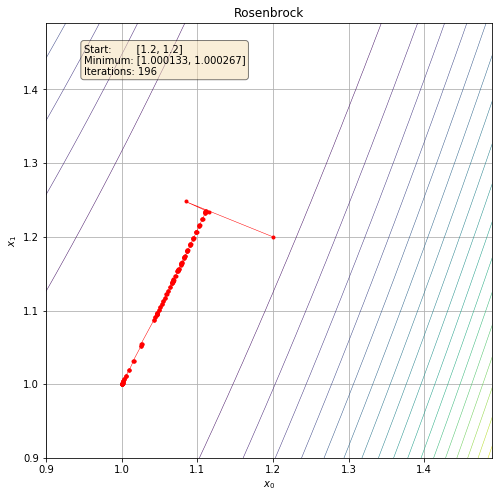

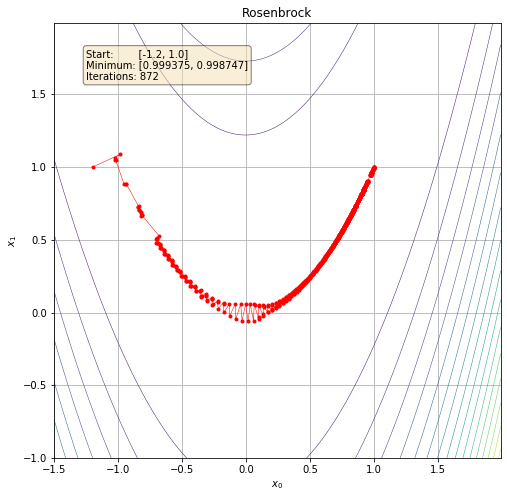

In [348]:
# Rosenbrock

a = 1
b = 100

f = lambda x: (a - x[0])**2 + b*(x[1] - x[0]**2)**2

df = lambda x: np.array([-2.0 * (a - x[0]) - 4.0 * b * x[0] * (x[1] - x[0]**2),
                         2.0 * b * (x[1] - x[0]**2)])

# rosenbrock_0.pdf

x0 = np.array([1.2, 1.2], dtype=np.float64)
iters, xs = steepest_descent(f, df, x0)

x = np.arange(0.9, 1.5, 0.01)
y = np.arange(0.9, 1.5, 0.01)
xx, yy = np.meshgrid(x, y)
z = (a - xx)**2 + b * (yy - xx**2)**2

plt.figure(figsize=(8, 8))
plt.contour(x,y,z, linewidths=0.5, levels=20)
plt.plot(xs[:, 0], xs[:, 1], '-ro', linewidth=0.5, markersize=3)
plt.title("Rosenbrock")
s1 = "Start:        [{:.1f}, {:.1f}]\n".format(x0[0], x0[1])
s2 = "Minimum: [{:.6f}, {:.6f}]\n".format(xs[-1][0], xs[-1][1])
s3 = "Iterations: {}".format(iters)
box_prop = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.95, 1.42, s1 + s2 + s3, bbox=box_prop)
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.grid()
plt.savefig("rosenbrock_0.pdf")
plt.show()


# rosenbrock_1.pdf

x0 = np.array([-1.2, 1.0], dtype=np.float64)
iters, xs = steepest_descent(f, df, x0)

x = np.arange(-1.5, 2.0, 0.01)
y = np.arange(-1.0, 2.0, 0.01)
xx, yy = np.meshgrid(x, y)
z = (a - xx)**2 + b * (yy - xx**2)**2

plt.figure(figsize=(8, 8))
plt.contour(x,y,z, linewidths=0.5, levels=20)
plt.plot(xs[:, 0], xs[:, 1], '-ro', linewidth=0.5, markersize=3)
plt.title("Rosenbrock")
s1 = "Start:        [{:.1f}, {:.1f}]\n".format(x0[0], x0[1])
s2 = "Minimum: [{:.6f}, {:.6f}]\n".format(xs[-1][0], xs[-1][1])
s3 = "Iterations: {}".format(iters)
box_prop = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-1.25, 1.6, s1 + s2 + s3, bbox=box_prop)
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.grid()
plt.savefig("rosenbrock_1.pdf")
plt.show()

In [490]:
# SVM implementation functions.

def dual_solver_quadratic_penalty(X, y, kernel):
    L = len(X)
    H = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            H[i, j] = y[i] * y[j] * kernel(X[i], X[j])            
    return H

def dual_solver_kkt_system(X, y, kernel):
    L = len(X)
    P = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            P[i, j] = y[i] * y[j] * kernel(X[i], X[j])
    q = np.full((L), -1.0)
    A = y
    KKT = np.zeros((L + 1, L + 1))
    KKT[0:L, 0:L] = P
    KKT[L, 0:L] = A
    KKT[0:L, L] = A
    RHS = np.zeros((L + 1))
    RHS[0:L] = -1.0 * q
    return np.linalg.solve(KKT, RHS)[0:L]

def w_func(X, y, alphas):
    L = len(X)
    w = np.zeros((L))
    for i in range(L):
        w += alphas[i] * y[i] * X[i]
    return w

#def b_func(X, y, alphas):
#    b = 0.0
#    S = np.where(alphas > 0.0)
#    for s in np.nditer(S):
#        inner = 0.0
#        for m in np.nditer(S):
#            inner += np.dot(alphas[m] * y[m] * X[m], X[s])
#        b += y[s] - inner
#    return b / len(S)


def b_func(X, y, alphas, w):
    b = 0.0
    S = np.where(alphas > 0.0)
    for s in np.nditer(S):
        b += y[s] - np.dot(w, X[s])
    return b / len(S)
        
def svm(X, y, dual_solver, kernel):
    alphas = dual_solver(X, y, kernel)
    w = w_func(X, y, alphas)
    b = b_func(X, y, alphas, w)
    return (alphas, w, b)

In [491]:
# Kernel functions.

#def kernel_linear(xi, xj):
#    return np.dot(xi, xj)

kernel_linear = lambda xi, xj: np.dot(xi, xj)


In [492]:
# Basic functionality test.

X = np.array([[1.0, 1.0],
              [5.0, 3.0]])

y = np.array([-1.0, +1.0])
              
alphas, w, b = svm(X, y, dual_solver_kkt_system, kernel_linear)

print(alphas)
print(w)
print(b)

[0.1 0.1]
[0.4 0.2]
-3.2


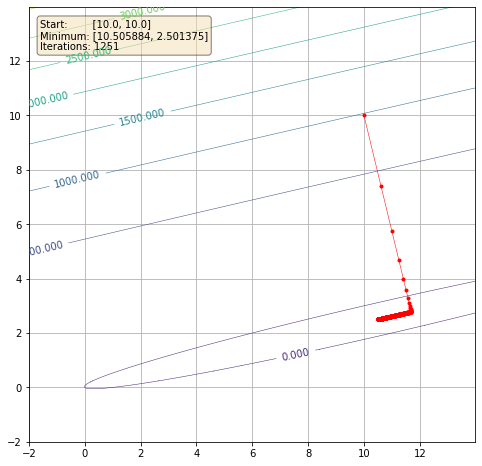

In [352]:
f = lambda x : x[0]**2 + 17 * x[1]**2 - 8.0 * x[0] * x[1] - x[0] - x[1]

df = lambda x : np.array([2.0 * x[0] - 8.0 * x[1] - 1.0,
                          34.0 * x[1] - 8.0 * x[0] - 1.0])
                     
x0 = np.array([10.0, 10.0], dtype=np.float64)

iters, xs = steepest_descent(f, df, x0)

x = np.arange(-2.0, 14.0, 0.01)
y = np.arange(-2.0, 14.0, 0.01)
xx, yy = np.meshgrid(x, y)
z = xx**2 + 17.0 * yy**2 - 8.0 * xx * yy - xx - yy

plt.figure(figsize=(8, 8))
cs = plt.contour(x,y,z, linewidths=0.5)
plt.clabel(cs)
plt.plot(xs[:, 0], xs[:, 1], '-ro', linewidth=0.5, markersize=3)
s1 = "Start:        [{:.1f}, {:.1f}]\n".format(x0[0], x0[1])
s2 = "Minimum: [{:.6f}, {:.6f}]\n".format(xs[-1][0], xs[-1][1])
s3 = "Iterations: {}".format(iters)
box_prop = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-1.6, 12.4, s1 + s2 + s3, bbox=box_prop)
plt.grid()
plt.savefig("motiv_0.pdf")
plt.show()

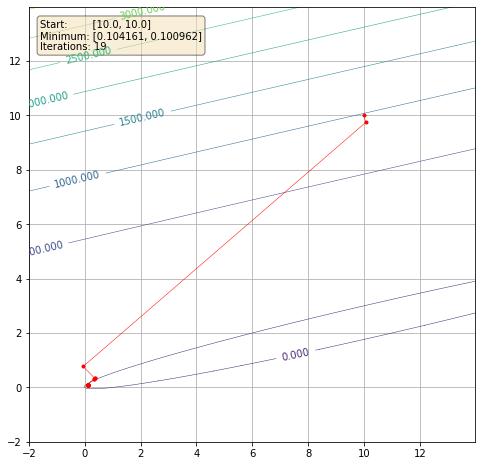

In [357]:
# Quadratic Penalty Method for solving the Dual Problem.

mu = 500

f = lambda x : x[0]**2 + 17 * x[1]**2 - 8.0 * x[0] * x[1] - x[0] - x[1] + mu / 2.0 * (-1.0 * x[0] + 1.0 *x[1])**2

df = lambda x : np.array([2.0 * x[0] - 8.0 * x[1] - 1.0 - mu * (-1.0 * x[0] + 1.0 * x[1]),
                          34.0 * x[1] - 8.0 * x[0] - 1.0 + mu * (-1.0 * x[0] + 1.0 * x[1])])
                     
x0 = np.array([10.0, 10.0], dtype=np.float64)

iters, xs = steepest_descent(f, df, x0)

alphas = xs[-1]

x = np.arange(-2.0, 14.0, 0.01)
y = np.arange(-2.0, 14.0, 0.01)
xx, yy = np.meshgrid(x, y)
z = xx**2 + 17.0 * yy**2 - 8.0 * xx * yy - xx - yy

plt.figure(figsize=(8, 8))
cs = plt.contour(x,y,z, linewidths=0.5)
plt.clabel(cs)
plt.plot(xs[:, 0], xs[:, 1], '-ro', linewidth=0.5, markersize=3)
s1 = "Start:        [{:.1f}, {:.1f}]\n".format(x0[0], x0[1])
s2 = "Minimum: [{:.6f}, {:.6f}]\n".format(xs[-1][0], xs[-1][1])
s3 = "Iterations: {}".format(iters)
box_prop = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-1.6, 12.4, s1 + s2 + s3, bbox=box_prop)
plt.grid()
plt.savefig("motiv_1.pdf")
plt.show()

In [358]:
support_vectors = X[alphas > 0.0]  # np.finfo(np.float64).eps

In [359]:
alphas

array([0.10416098, 0.10096218])

In [360]:
support_vectors

array([[1., 1.],
       [5., 3.]])

In [361]:
np.finfo(np.float64).eps

2.220446049250313e-16

In [381]:
b = np.zeros((3))

In [382]:
b

array([0., 0., 0.])

In [470]:
from scipy.optimize import minimize

rosen = lambda x: (1.0 - x[0])**2.0 + 100.0 * (x[1]-x[0]**2.0)**2.0

f = lambda x: x[0]**2.0 + 17.0 * x[1]**2.0 - 8.0 * x[0] * x[1] - x[0] - x[1]

eq_cons = {'type': 'eq', 'fun' : lambda x: np.array(x[1] - x[0])}

ineq_cons = {'type': 'ineq', 'fun' : lambda x: np.array(x[0], x[1])}

x0 = np.array([10.0, 10.0])

minimize(f, x0, method='SLSQP', constraints=[eq_cons, ineq_cons], options={'ftol': 1e-6})

     fun: -0.09999999999999822
     jac: array([-1.5999999 ,  1.59999991])
 message: 'Optimization terminated successfully.'
    nfev: 12
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.09999999, 0.09999999])

In [493]:
from sklearn.svm import LinearSVC

svm = LinearSVC(C=1)

X = np.array([[1.0, 1.0],
              [5.0, 3.0]])

y = np.array([-1.0, +1.0])
              
svm.fit(X, y)


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [501]:
svm.predict([[1.0, 7.0]])

array([-1.])